In [1]:
#  Setup Define paths, import libraries, and create necessary folders

# Base folder path
BASE_DIR  = r"E:\AIML"     
# Dataset file path
DATA_PATH = rf"E:\AIML\dataset\heart_attack_prediction_dataset.csv"
# Folder for EDA graphs
EDA_DIR   = rf"E:\AIML\results\eda_visualizations"
# Folder for outputs
OUT_DIR   = rf"E:\AIML\results\outputs"

# Import libraries
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer            # fill missing data
from sklearn.preprocessing import OneHotEncoder     # convert text → numbers
from sklearn.preprocessing import StandardScaler    # scale data (normal)
from sklearn.preprocessing import RobustScaler      # scale data (outlier safe)
from sklearn.feature_selection import mutual_info_classif  # feature importance
from sklearn.decomposition import PCA               # reduce dimensions

# Try importing SMOTE (for balancing data)
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    SMOTE = None  # If not available, set None

# Ignore warning messages
warnings.filterwarnings("ignore")

# Create folders if not exist
os.makedirs(EDA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Target column name
TARGET = "Heart Attack Risk"
# Random seed number (for repeatable results)
RANDOM_STATE = 42

In [2]:
# Database Load & Split (Load CSV dataset, check target column, and split into train/test sets.) 

# Read CSV file into DataFrame
df = pd.read_csv(DATA_PATH)

# Check target column exists
assert TARGET in df.columns, f"TARGET '{TARGET}' not found. Columns: {list(df.columns)}"

# List of ID-like column names (not useful for model)
id_like = {"patient id","id","record id"}

# Find matching ID columns in dataset
drop_ids = [c for c in df.columns if c.strip().lower() in id_like]

# If found, drop those ID columns
if drop_ids:
    df = df.drop(columns=drop_ids)

# Features (X) = all columns except target
X = df.drop(columns=[TARGET]).copy()

# Labels (y) = target column
y = df[TARGET].values

# For stratified split: only if target has <= 20 unique classes
strat = y if pd.Series(y).nunique() <= 20 else None

# Split dataset : 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=strat
)

# Show train/test set sizes
print("Train/Test:", X_train.shape, X_test.shape)


Train/Test: (7010, 24) (1753, 24)


In [3]:
#   Column Type (Identify which columns are categorical and which are numeric)

# Threshold: if unique values <= 12 → treat as categorical
LOW_CARD_AS_CAT = 12

# List to hold categorical column names
categorical_cols = []

# Go through each column in training data
for c in X_train.columns:
    # If column is string type → categorical
    if X_train[c].dtype == "object":
        categorical_cols.append(c)
    else:
        # If column is numeric but has few unique values → categorical
        if X_train[c].nunique(dropna=True) <= LOW_CARD_AS_CAT:
            categorical_cols.append(c)

# Numeric = number columns that are NOT categorical
numeric_cols = [c for c in X_train.select_dtypes(include="number").columns if c not in categorical_cols]

# Print results
print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

#%%


Categorical: ['Sex', 'Blood Pressure', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere']
Numeric: ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides']


In [4]:
#  Imputation, (Fill missing values: numeric → median, categorical → most frequent) 
import os

# Paths to save/load imputed train & test
train_imp_path = os.path.join(OUT_DIR, "X_train_imputed.csv")
test_imp_path  = os.path.join(OUT_DIR, "X_test_imputed.csv")

# If imputed files already exist → load them
if os.path.exists(train_imp_path) and os.path.exists(test_imp_path):
    print("Loading imputed splits from outputs/...")
    # Load train, drop target if exists
    X_train_imp = pd.read_csv(train_imp_path).drop(columns=[TARGET], errors="ignore")
    # Load test, drop target if exists
    X_test_imp  = pd.read_csv(test_imp_path).drop(columns=[TARGET], errors="ignore")

# Else → do imputation locally
else:
    print("Imputing locally (median numeric, most_frequent categorical)...")

    # For numbers: fill missing with median
    num_imputer = SimpleImputer(strategy="median")
    # For categories: fill missing with most common value
    cat_imputer = SimpleImputer(strategy="most_frequent")

    # Train numeric imputed
    X_train_num = num_imputer.fit_transform(X_train[numeric_cols]) if numeric_cols else None
    # Test numeric imputed (use same fit)
    X_test_num  = num_imputer.transform(X_test[numeric_cols])      if numeric_cols else None

    # Train categorical imputed
    X_train_cat = cat_imputer.fit_transform(X_train[categorical_cols]) if categorical_cols else None
    # Test categorical imputed
    X_test_cat  = cat_imputer.transform(X_test[categorical_cols])      if categorical_cols else None

    # Collect processed parts
    tr_parts, te_parts = [], []

    # If numeric exists → add DataFrame back
    if X_train_num is not None:
        tr_parts.append(pd.DataFrame(X_train_num, columns=numeric_cols, index=X_train.index))
        te_parts.append(pd.DataFrame(X_test_num,  columns=numeric_cols, index=X_test.index))

    # If categorical exists → add DataFrame back
    if X_train_cat is not None:
        tr_parts.append(pd.DataFrame(X_train_cat, columns=categorical_cols, index=X_train.index))
        te_parts.append(pd.DataFrame(X_test_cat,  columns=categorical_cols, index=X_test.index))

    # Merge numeric + categorical parts
    X_train_imp = pd.concat(tr_parts, axis=1) if tr_parts else pd.DataFrame(index=X_train.index)
    X_test_imp  = pd.concat(te_parts, axis=1) if te_parts else pd.DataFrame(index=X_test.index)

# Show final shapes
print("Imputed shapes:", X_train_imp.shape, X_test_imp.shape)

Imputing locally (median numeric, most_frequent categorical)...
Imputed shapes: (7010, 24) (1753, 24)


In [5]:
#  C1: Choose continuous numeric columns with unique values

# Threshold: if unique values > 10 → consider continuous
CONT_UNIQUE_THRESH = 10

# Pick numeric columns with enough unique values
cont_cols = [c for c in X_train.select_dtypes(include="number").columns 
             if c in X_train_imp.columns and X_train_imp[c].nunique() > CONT_UNIQUE_THRESH]

# Show continuous numeric columns
print("Continuous numeric columns:", cont_cols)

Continuous numeric columns: ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides']


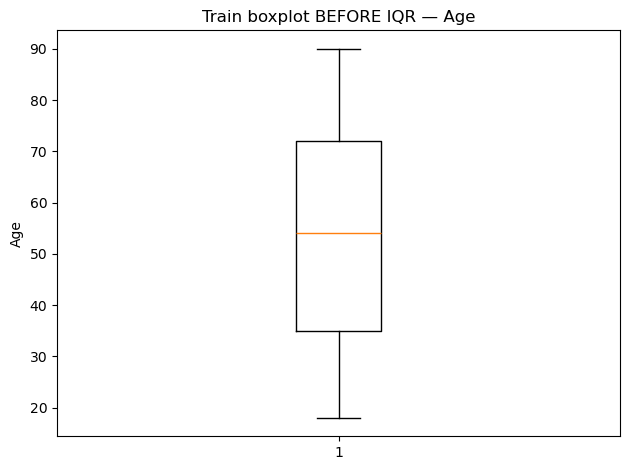

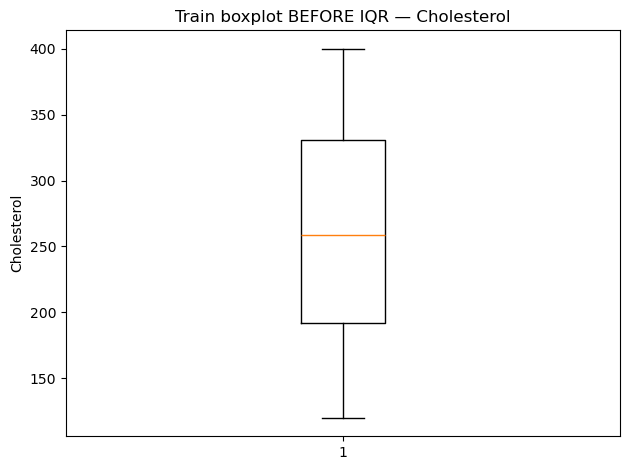

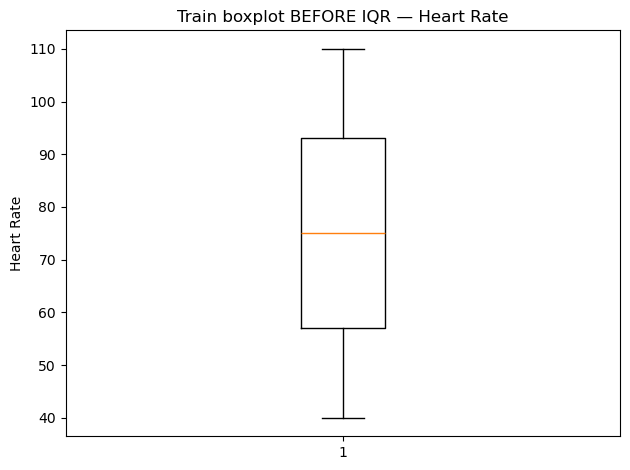

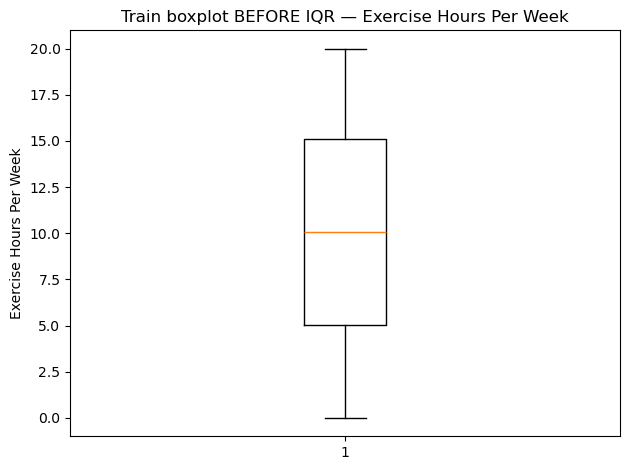

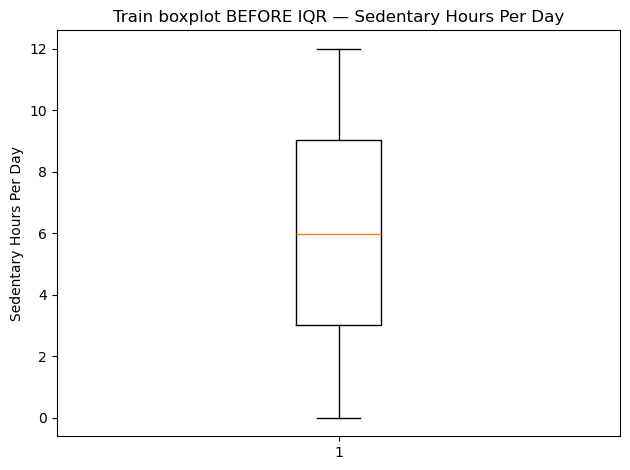

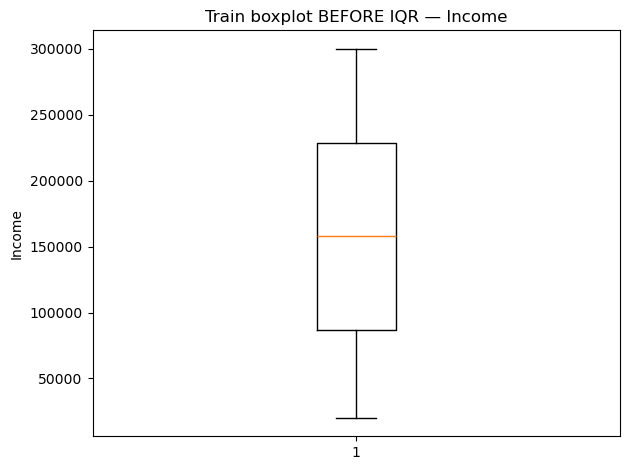

IQR kept 7010/7010 rows (removed 0).


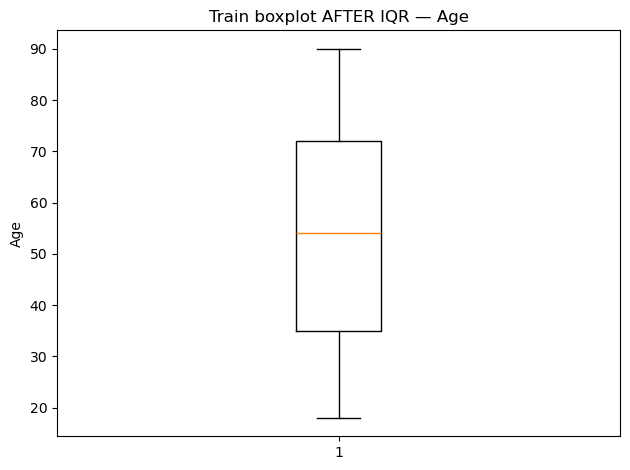

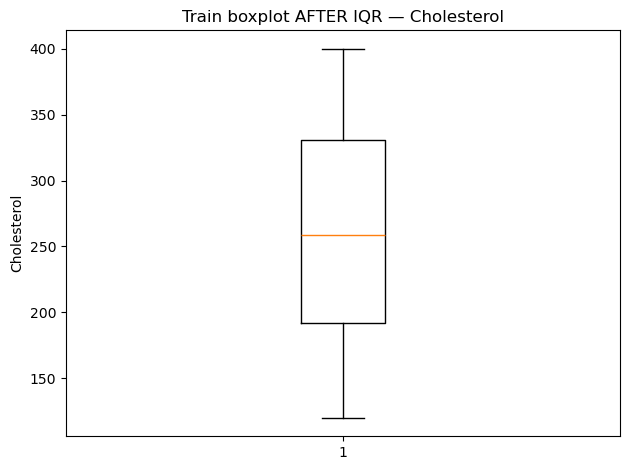

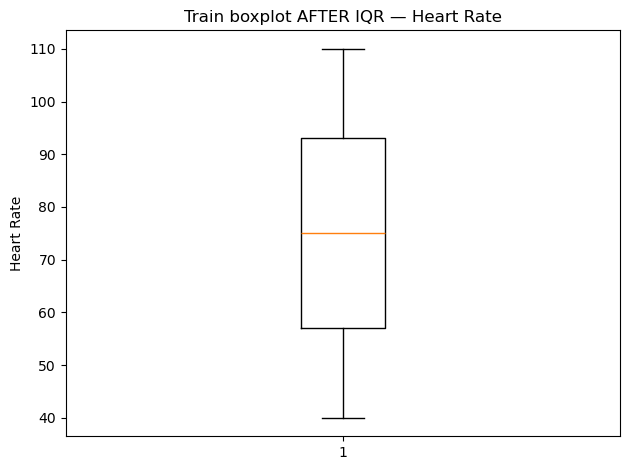

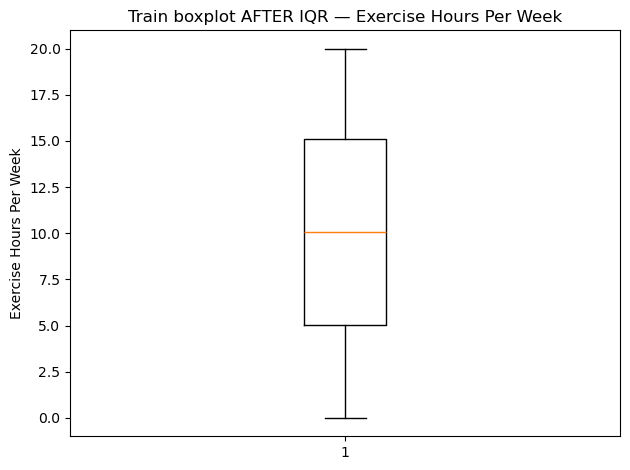

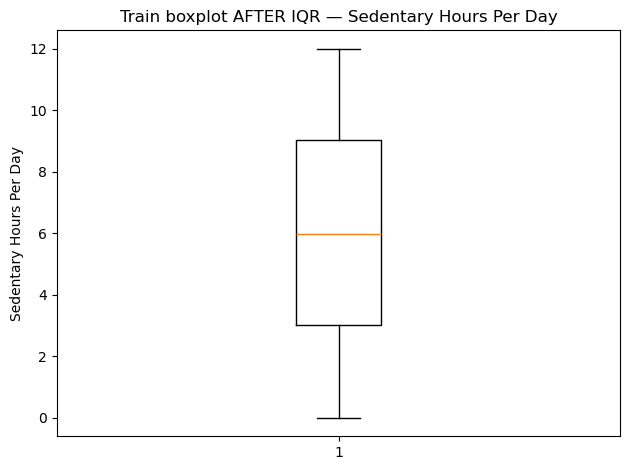

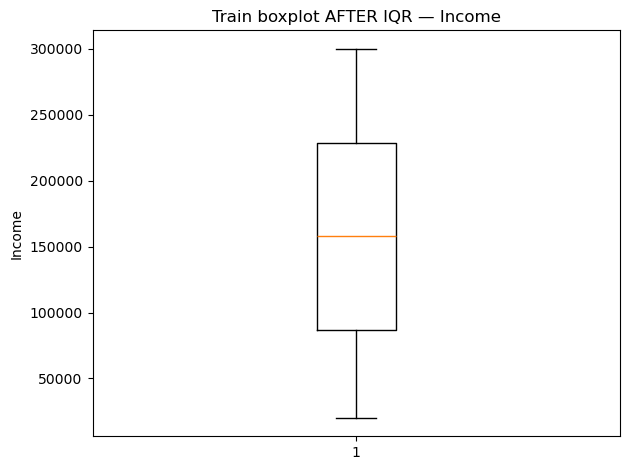

Saved: C_X_train_imputed_iqr.csv


In [6]:
#  IQR Filter (Remove outliers using the IQR method, visualize with boxplots, and save filtered train data)

# Show boxplots for first 6 continuous columns before filtering
for c in cont_cols[:6]:
    plt.figure()                              # new figure
    plt.boxplot(X_train_imp[c].dropna())      # plot boxplot, ignore NaNs
    plt.title(f"Train boxplot BEFORE IQR — {c}")  # add title
    plt.ylabel(c)                             # y-axis label
    plt.tight_layout()                        # adjust layout
    plt.savefig(os.path.join(EDA_DIR, f"box_before_{c}.png"))  # save figure
    plt.show()                                # display figure

# Function: generate mask for rows within IQR
def iqr_mask(df_cont: pd.DataFrame) -> pd.Series:
    m = pd.Series(True, index=df_cont.index)   # start with all True
    for col in df_cont.columns:
        Q1, Q3 = df_cont[col].quantile(0.25), df_cont[col].quantile(0.75)  # quartiles
        IQR = Q3 - Q1                          # interquartile range
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR  # bounds
        m &= (df_cont[col] >= lower) & (df_cont[col] <= upper)  # keep only in range
    return m

# Apply IQR filter if there are continuous columns
if cont_cols:
    mask = iqr_mask(X_train_imp[cont_cols])   # get mask of rows within IQR
    kept = int(mask.sum()); total = len(mask) # count kept vs total
    print(f"IQR kept {kept}/{total} rows (removed {total-kept}).")
    
    # Filter X_train and y_train using mask
    X_train_iqr = X_train_imp.loc[mask].copy()
    y_train_iqr = pd.Series(y_train, index=X_train_imp.index).loc[mask].values
else:
    print("No continuous columns found. Skipping IQR.")
    X_train_iqr = X_train_imp.copy()
    y_train_iqr = y_train

# Show boxplots for first 6 continuous columns after filtering
for c in cont_cols[:6]:
    plt.figure()
    plt.boxplot(X_train_iqr[c].dropna())
    plt.title(f"Train boxplot AFTER IQR — {c}")
    plt.ylabel(c)
    plt.tight_layout()
    plt.savefig(os.path.join(EDA_DIR, f"box_after_{c}.png"))
    plt.show()

# Save IQR-filtered TRAIN data with target
pd.concat([X_train_iqr, pd.Series(y_train_iqr, index=X_train_iqr.index, name=TARGET)], axis=1)\
  .to_csv(os.path.join(OUT_DIR, "C_X_train_imputed_iqr.csv"), index=False)
print("Saved: C_X_train_imputed_iqr.csv")
